In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from infra.model_base import ModelBase
import requests
import shutil
import pathlib
import pickle

In [3]:
r = requests.get("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", stream=True)
download = pathlib.Path("./temp")
if not download.exists():
    download.mkdir(parents=True)
download = download / "cifar-10.tar.gz"
with download.open("wb") as fout:
    shutil.copyfileobj(r.raw, fout)

In [10]:
!tar -xvzf ./temp/cifar-10.tar.gz -C ./temp 
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
batch_1 = unpickle("./temp/cifar-10-batches-py/data_batch_1")

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [53]:
class TestNet(ModelBase):
    def __init__(self, *args, **kwargs):
        super(TestNet, self).__init__(*args, **kwargs)
        self.conv1 = torch.nn.Conv2d(3, 8, 3, padding="same")
        self.bn1 = torch.nn.BatchNorm2d(8)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(8, 32, 3, padding="same")
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding="same")
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(1024, 256)
        self.linear2 = torch.nn.Linear(256, 10)
        self.dropout = torch.nn.Dropout(p=0.5)

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [54]:
class CifarDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, dtype=torch.float32, device="cpu", batches=5):
        self.counter = 0
        self.image_dir = pathlib.Path(image_dir)
        self.dtype = torch.float64
        self.device = device
        self.X = torch.zeros(batches*10000,3072, dtype=self.dtype, device=self.device)
        self.y = torch.zeros(batches*10000, dtype=torch.int64, device=self.device)
        self.batches = batches

        self.mean = torch.zeros(3,dtype=self.dtype, device=self.device)
        self.std = torch.zeros(3, dtype=self.dtype, device=self.device)
        for i in range(batches):
            batch_dir = self.image_dir / f"data_batch_{i+1}"
            with batch_dir.open("rb") as fin:
                data = pickle.load(fin, encoding="bytes")
            X = torch.from_numpy(data[b"data"]).to(self.dtype).to(self.device)
            y = torch.tensor(data[b"labels"]).to(dtype=torch.int64).to(self.device)
            self.X[i:i+10000] = X
            self.y[i:i+10000] = y
            X_view = X.view(-1,3,32,32)
            self.mean += torch.mean(X_view, dim=(0,2,3))
            self.std += torch.std(X_view, dim=(0,2,3))**2
        self.mean /= 5
        self.std /= 5
        self.std = torch.sqrt(self.std)

    def __len__(self):
        return self.batches * 10000

    def __getitem__(self, idx):
        X, y = self.X[idx].view(3,32,32), self.y[idx]
        X = (X - self.mean.view(-1,1,1))/self.std.view(-1,1,1)
        return X, y

class CifarTestDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, dtype=torch.float32, device="cpu"):
        self.counter = 0
        self.image_dir = pathlib.Path(image_dir)
        self.dtype = torch.float64
        self.device = device
        self.X = torch.zeros(10000,3072, dtype=self.dtype, device=self.device)
        self.y = torch.zeros(10000, dtype=torch.int64, device=self.device)

        self.mean = torch.zeros(3,dtype=self.dtype, device=self.device)
        self.std = torch.zeros(3, dtype=self.dtype, device=self.device)
        batch_dir = self.image_dir / "test_batch"
        with batch_dir.open("rb") as fin:
            data = pickle.load(fin, encoding="bytes")
        X = torch.from_numpy(data[b"data"]).to(self.dtype).to(self.device)
        y = torch.tensor(data[b"labels"]).to(dtype=torch.int64).to(self.device)
        self.X = X
        self.y = y
        X_view = X.view(-1,3,32,32)
        self.mean += torch.mean(X_view, dim=(0,2,3))
        self.std += torch.std(X_view, dim=(0,2,3))**2
        self.mean /= 5
        self.std /= 5
        self.std = torch.sqrt(self.std)

    def __len__(self):
        return 10000

    def __getitem__(self, idx):
        X, y = self.X[idx].view(3,32,32), self.y[idx]
        X = (X - self.mean.view(-1,1,1))/self.std.view(-1,1,1)
        return X, y


In [71]:
training_data = CifarDataset("./temp/cifar-10-batches-py", device="cuda", batches=5)
test_data = CifarTestDataset("./temp/cifar-10-batches-py", device="cuda")

In [72]:
loss = torch.nn.CrossEntropyLoss()
model = TestNet("./temp/checkpoint")
optimizer = torch.optim.Adam(model.parameters(), 5e-4)

In [73]:
model.double()
model.cuda()
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
for i in range(20):
    for iteration, (X,y) in enumerate(train_loader):
        pred = model(X)
        l = loss(pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print(f"Epoch {i}: loss = {l.item()}")

Epoch 0: loss = 0.5264429248336295
Epoch 1: loss = 0.7517365796467639
Epoch 2: loss = 0.15024286459023886
Epoch 3: loss = 0.08578587206129741
Epoch 4: loss = 0.13616691289448563
Epoch 5: loss = 0.1893062462051992
Epoch 6: loss = 0.08541804982544826
Epoch 7: loss = 0.3818427237438626
Epoch 8: loss = 0.28565475118634226
Epoch 9: loss = 0.14231828699693586
Epoch 10: loss = 0.08811586082764478
Epoch 11: loss = 0.050778152005478014
Epoch 12: loss = 0.013205246640883777
Epoch 13: loss = 0.16429552919107984
Epoch 14: loss = 0.0717465898248458
Epoch 15: loss = 0.010707266170699597
Epoch 16: loss = 0.19320338457645678
Epoch 17: loss = 0.01084233203798644
Epoch 18: loss = 0.012503852662228277
Epoch 19: loss = 0.12082582116207229


tensor(2, device='cuda:0')
tensor([6], device='cuda:0')


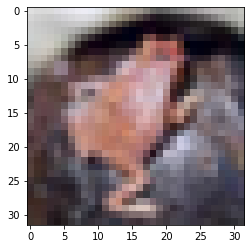

In [87]:
import matplotlib.pyplot as plt
import random

test_loader = torch.utils.data.DataLoader(test_data)
test_iter = iter(test_loader)
for i in range(random.randint(0,9999)):
    next(test_iter)
model.eval()
with torch.no_grad():
    X,y = next(test_iter)
    pred = model(X)
    cpu = X.clone().cpu()[0]
    cpu *= test_data.std.view(-1,1,1).cpu()
    cpu += test_data.mean.view(-1,1,1).cpu()
    plt.imshow(cpu.permute(1, 2, 0)/255.0)
    print(torch.argmax(pred))
    print(y)

In [81]:
print(model.summary())

Model:
══════════════════════════════════════════════════
conv1: Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same) - 224 parameters
──────────────────────────────────────────────────
bn1: BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) - 16 parameters
──────────────────────────────────────────────────
relu: ReLU() - 0 parameters
──────────────────────────────────────────────────
maxpool: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) - 0 parameters
──────────────────────────────────────────────────
conv2: Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=same) - 2336 parameters
──────────────────────────────────────────────────
bn2: BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) - 64 parameters
──────────────────────────────────────────────────
conv3: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same) - 18496 parameters
────────────────────────────────────────────

In [76]:
import matplotlib.pyplot as plt
import random

test_loader = torch.utils.data.DataLoader(test_data)
test_iter = iter(test_loader)
model.eval()
count = 0
with torch.no_grad():
    for X,y in test_loader:
        pred = model(X)
        if torch.argmax(pred) == y.item():
            count += 1
print(f"{count/10000}")

0.4881
